<a href="https://colab.research.google.com/github/annykay/NoiseInDataImpact/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing
<br>
Data preparation (including feature selection and modification, outliers dropout, etc. as well as ML classification models' hyperparameters optimization) steps are presented here. The main goal of this section is to generate dataframes and optimal models that would be further used for noise introduction simulations.
<br>
<br>
There are 4 different datasets and 5 ML models (DecisionTree, RandomForest, XGB, LogisticRegression, KNearestNeighbors).

In [1]:
# Imports 

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier


import warnings
warnings.filterwarnings('ignore')

### Stellar classification Dataset
Heavenly body type classification by its spectral properties<br>
Source: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17
<br>
Preparation pipeline is partially based on: https://www.kaggle.com/code/beyzanks/stellar-classification-98-4-acc-100-auc/notebook<br><br>
**General info:**<br>
*Size:* 51000<br>
*Variables type:* quantitative<br>
*Number of classes:* 3<br>
*Classes balance:* 1.1 / 1 / 1<br>
<br>

In [ ]:
# Loading the raw data and changing class labels to integers

df = pd.read_csv(r'C:\\Users\gangs\Downloads\star_classification.csv', engine='python')
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

In [ ]:
# Deleting outliers

clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df)
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score
threshold2 = -1.5                                            
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()
df.drop(outlier_index, inplace=True)

In [ ]:
# Deleting uncorrelated with target variable features

df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

In [ ]:
# Downsampling of major class to make data balanced

df_0 = df[df['class']==0]
df_1 = df[df['class']==1]
df_2 = df[df['class']==2]

df_0_downsampled = resample(df_0, replace=False, n_samples=17000, random_state=123)
df_downsampled = pd.concat([df_0_downsampled, df_1, df_2])

In [ ]:
stellar_x = df_downsampled.drop(['class'], axis = 1)
stellar_y = df_downsampled.loc[:,'class'].values

In [ ]:
# Data scaling and train-test splitting

stellar_x = StandardScaler().fit_transform(stellar_x)
X_train, X_test, y_train, y_test = train_test_split(stellar_x, stellar_y, test_size = 0.3, random_state = 123)

In [ ]:
# Models optimization

RandomForest = GridSearchCV(
    RandomForestClassifier(random_state=0),
    {'max_depth': [i for i in range(12, 15)], 'n_estimators': [80, 90, 100]},
    scoring = 'f1_micro',
    cv = 3,
    n_jobs=-1
)
RandomForest.fit(X_train, y_train)
print('RandomForestClassifier\nbest parameters:', RandomForest.best_params_)
print('Train score: {}\nTest score: {}'.format(
    f1_score(y_train, RandomForest.predict(X_train), average='micro'),
    f1_score(y_test, RandomForest.predict(X_test), average='micro')
    )
)

DecisionTree = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    {'max_depth': [i for i in range(7, 11)]},
    scoring = 'f1_micro',
    cv = 3,
    n_jobs=-1
)
DecisionTree.fit(X_train, y_train)
print('\nDecisionTree\nbest parameters:', DecisionTree.best_params_)
print('Train score: {}\nTest score: {}'.format(
    f1_score(y_train, DecisionTree.predict(X_train), average='micro'),
    f1_score(y_test, DecisionTree.predict(X_test), average='micro')
    )
)

KNN = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': [i for i in range(1, 5)]},
    scoring = 'f1_micro',
    cv = 3,
    n_jobs=-1
)
KNN.fit(X_train, y_train)
print('\nKNearestNeigbors\nbest parameters:', KNN.best_params_)
print('Train score: {}\nTest score: {}'.format(
    f1_score(y_train, KNN.predict(X_train), average='micro'),
    f1_score(y_test, KNN.predict(X_test), average='micro')
    )
)

XGB = GridSearchCV(
    XGBClassifier(random_state=0),
    {'max_depth': [15, 10, 12], 'n_estimators': [100, 80, 120], 'learning_rate': [0.1, 0.2, 0.05]},
    cv = 3,
    scoring='f1_micro',
    n_jobs=-1
)
XGB.fit(X_train, y_train)
print('\nXGBoostClassifier\nbest parameters:', XGB.best_params_)
print('Train score: {}\nTest score: {}'.format(
    f1_score(y_train, XGB.predict(X_train), average='micro'),
    f1_score(y_test, XGB.predict(X_test), average='micro')
    )
)

LogReg = GridSearchCV(
    LogisticRegression(random_state=0, max_iter=1000),
    {'C': np.arange(1900, 2200, 10)},
    cv = 3,
    scoring='f1_micro',
    n_jobs=-1
)
LogReg.fit(X_train, y_train)
print('\nLogisticregression\nbest parameters:', LogReg.best_params_)
print('Train score: {}\nTest score: {}'.format(
    f1_score(y_train, LogReg.predict(X_train), average='micro'),
    f1_score(y_test, LogReg.predict(X_test), average='micro')
    )
)

RandomForestClassifier
best parameters: {'max_depth': 14, 'n_estimators': 90}
Train score: 0.9925838860437131
Test score: 0.9770812928501469

DecisionTree
best parameters: {'max_depth': 9}
Train score: 0.9817255757982817
Test score: 0.9714005876591577

KNearestNeigbors
best parameters: {'n_neighbors': 3}
Train score: 0.9650463157305572
Test score: 0.9463271302644466

XGBoostClassifier
best parameters: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100}
Train score: 0.9993563372792656
Test score: 0.9756447926869083

Logisticregression
best parameters: {'C': 2010}
Train score: 0.9584417765091092
Test score: 0.9598432908912831


### Rice type classification Dataset
Determination of rice sort (Jasmine - 1, Gonen - 0) based on its quantitative characteristics (area, axis lenght, etc.).
<br>
Source: https://www.kaggle.com/mssmartypants/rice-type-classification
<br><br>
**General info:**<br>
*Size:* 18000<br>
*Variables type:* quantitative<br>
*Number of classes:* 2<br>
*Classes balance:* 1.2 / 1<br>
<br>
According to kaggle description, this dataset was preproseed before and does not require any additional operations on it.<br><br>
ML models show sufficient preformance with default parameters.

### Pulsars classification Dataset
Pulsars prediction by using neutron star pulse profile<br>
Source: https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate<br><br>
**General info:**<br>
*Size:* 18000<br>
*Variables type:* quantitative<br>
*Number of classes:* 2<br>
*Classes balance:* 9.9 / 1<br>

In [ ]:
# We will define some functions that will automatize data downloading, processing and hyperparameters optimization

DATASETS = [
    {
        'name': 'Pulsars',
        'features': 'Pulsars_features.csv',
        'labels': 'Pulsars_labels.csv'
    }
]   

clfs = {
    'DTC': DecisionTreeClassifier,
    'RFC': RandomForestClassifier,
    'LTC': LogisticRegression,
    'XGB': XGBClassifier,
    'KNC': KNeighborsClassifier,
}

grd_pars = {
    'max_depth': [5, 8, 15, 30],
    'criterion': ['gini', 'entropy'],
    'max_features': [2, 5, 8, 12, 16, 20, 25, None],
    'n_estimators': [20, 40, 60, 80],
    'n_neighbors': [1, 3, 6, 9, 12, 15],
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
    'C': [ 0.5, 1, 5, 10 ],
}

mdl_pars = [
     ['max_depth', 'criterion'],
     ['max_depth', 'max_features', 'n_estimators'],
     ['C',],
     ['max_depth', 'n_estimators', 'learning_rate'],
     ['n_neighbors',],
]


In [ ]:
def non_categorical(dataset):
    features = []
    for col in dataset.columns:
        vals = np.sort(dataset[col].unique())
        if np.any(vals != np.array([0,1])):
            features.append(col)
    return features

def scale_data(X):
    nc_cols = non_categorical(X)
    sc = StandardScaler()
    X_s = pd.DataFrame(sc.fit_transform(X[nc_cols]), columns=nc_cols)
    return X_s

def best_params(X, y, clf, grid):
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0xC0FFEE)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0xC0FFEE)

    val_fold = 1 - 2*np.isin(X_train_val, X_val).all(axis=1).astype(int)
    ps = PredefinedSplit(val_fold)
    
    grd_clf = GridSearchCV(clf(), grid,
                  scoring = 'f1_micro', cv = ps, n_jobs=-1)

    grd_clf.fit(X_train_val, y_train_val)
    y_train_pred = grd_clf.best_estimator_.predict(X_train)

    grd_clf.best_estimator_.fit(X_train, y_train)
    y_test_pred = grd_clf.best_estimator_.predict(X_test)

    train_score = round(f1_score(y_train, y_train_pred, average='weighted'), 2)
    test_score = round(f1_score(y_test, y_test_pred, average='weighted'), 2)
    
    return train_score, test_score, grd_clf.best_params_

mdl_vals = {}

names, models = list(clfs.keys()), list(clfs.values())
for model, clf, params in tqdm(zip(names, models, mdl_pars), total=len(mdl_pars)):
    mdl_vals[model] = {key: [] for key in params}
    for DATA in DATASETS:
        X = pd.read_csv(DATA['features']).drop('Unnamed: 0', axis=1)
        y = pd.read_csv(DATA['labels']).drop('Unnamed: 0', axis=1)
        
        X_s = scale_data(X)

        grid = { key: grd_pars[key] for key in params }
        train_score, test_score, parameters = best_params(X_s, y, clf, grid)
        
        print(model, DATA['name'], train_score, test_score)
        print(parameters)
        
        for key in parameters:
            mdl_vals[model][key].append(parameters[key])
        
print(mdl_vals)

 20%|██        | 1/5 [00:00<00:01,  3.43it/s]

DTC Pulsars 0.98 0.97
{'criterion': 'entropy', 'max_depth': 5}


 40%|████      | 2/5 [00:16<00:29,  9.78s/it]

RFC Pulsars 0.98 0.98
{'max_depth': 5, 'max_features': None, 'n_estimators': 40}


 60%|██████    | 3/5 [00:16<00:10,  5.42s/it]

LTC Pulsars 0.98 0.98
{'C': 10}


 80%|████████  | 4/5 [00:23<00:05,  5.90s/it]

XGB Pulsars 1.0 0.98
{'learning_rate': 0.7, 'max_depth': 15, 'n_estimators': 80}


100%|██████████| 5/5 [00:24<00:00,  4.97s/it]

KNC Pulsars 0.98 0.97
{'n_neighbors': 3}
{'DTC': {'max_depth': [5], 'criterion': ['entropy']}, 'RFC': {'max_depth': [5], 'max_features': [None], 'n_estimators': [40]}, 'LTC': {'C': [10]}, 'XGB': {'max_depth': [15], 'n_estimators': [80], 'learning_rate': [0.7]}, 'KNC': {'n_neighbors': [3]}}


### Banking classification Dataset
Prediction of client subscription (y/n) for term deposit<br>
Source: https://www.kaggle.com/rashmiranu/banking-dataset-classification<br><br>
**General info:**<br>
*Size:* 33000<br>
*Variables type:* categorical<br>
*Number of classes:* 2<br>
*Classes balance:* 9.7 / 1<br>

In [ ]:
# We will use previously defined functions with extra label binarization to estimate the models' parameters 

DATASETS = [
    {
        'name': 'Banking',
        'features': 'bank_data_features.csv',
        'labels': 'bank_data_labels.csv'
    }
]  

mdl_vals = {}

names, models = list(clfs.keys()), list(clfs.values())
for model, clf, params in tqdm(zip(names, models, mdl_pars), total=len(mdl_pars)):
    mdl_vals[model] = {key: [] for key in params}
    for DATA in DATASETS:
        X = pd.read_csv(DATA['features'])
        y = pd.read_csv(DATA['labels'])
        
        lb = LabelBinarizer()
        X = pd.get_dummies(X)
        y = lb.fit_transform(y)

        grid = { key: grd_pars[key] for key in params }
        train_score, test_score, parameters = best_params(X_s, y, clf, grid)
        
        print(model, DATA['name'], train_score, test_score)
        print(parameters)
        
        for key in parameters:
            mdl_vals[model][key].append(parameters[key])
        
print(mdl_vals)

 20%|██        | 1/5 [00:01<00:06,  1.51s/it]

DTC Banking 0.91 0.89
{'criterion': 'gini', 'max_depth': 8}


 40%|████      | 2/5 [00:40<01:10, 23.64s/it]

RFC Banking 0.95 0.89
{'max_depth': 15, 'max_features': 2, 'n_estimators': 60}


 60%|██████    | 3/5 [00:41<00:26, 13.04s/it]

LTC Banking 0.89 0.89
{'C': 0.5}


 80%|████████  | 4/5 [02:10<00:43, 43.24s/it]

XGB Banking 0.91 0.89
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}


100%|██████████| 5/5 [02:12<00:00, 26.43s/it]

KNC Banking 0.9 0.89
{'n_neighbors': 15}
{'DTC': {'max_depth': [8], 'criterion': ['gini']}, 'RFC': {'max_depth': [15], 'max_features': [2], 'n_estimators': [60]}, 'LTC': {'C': [0.5]}, 'XGB': {'max_depth': [5], 'n_estimators': [80], 'learning_rate': [0.1]}, 'KNC': {'n_neighbors': [15]}}


## Feature Importance analysis

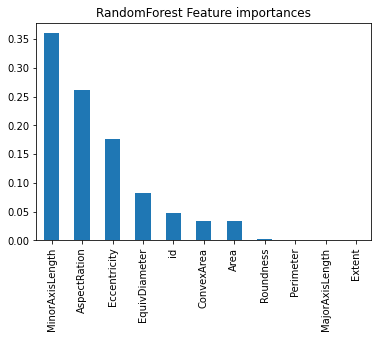

In [7]:
# Example based on preproceed Rice dataset

import matplotlib.pyplot as plt

rice_features = pd.read_csv('Rice_features.csv')
rice_labels = pd.read_csv('Rice_labels.csv')
rice_labels = rice_labels.drop('Unnamed: 0', axis=1)
rice_features = rice_features.drop('Unnamed: 0', axis=1)

clf = RandomForestClassifier(max_depth=5, n_estimators=30, n_jobs=-1).fit(rice_features, rice_labels)

fi_1 = pd.Series(clf.feature_importances_, index=rice_features.columns)
fi_1.sort_values(ascending=False).plot(kind='bar')
plt.title('RandomForest Feature importances')
plt.show()